# Block Encoding

High level bloqs for defining bloq encodings and operations on block encodings.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `BlockEncoding`
Abstract interface for an arbitrary block encoding.

In general, given an $s$-qubit operator $H$ then the $(s+a)$-qubit unitary $B[H] = U$ is
a $(\alpha, a, \epsilon)$-block encoding of $H$ if it satisfies:

$$
    \lVert H - \alpha (\langle G|_a\otimes I_s U |G\rangle_a \otimes I_s) \rVert
    \le \epsilon,
$$

where $a$ is an ancilla register and $s$ is the system register, $U$ is a unitary sometimes
called a signal oracle, $\alpha$ is a normalization constant chosen such
that  $\alpha \ge \lVert H\rVert$ (where $\lVert \cdot \rVert$ denotes the
spectral norm), and $\epsilon$ is the precision to which the block encoding
is prepared. The state $|G\rangle_a$ is sometimes called the signal state,
and its form depends on the details of the block encoding.

For LCU based block encodings with $H = \sum_l w_l U_l$
we have
$$
U = \sum_l |l\rangle\langle l| \otimes U_l
$$
and $|G\rangle = \sum_l \sqrt{\frac{w_l}{\alpha}}|l\rangle_a$, which define the
usual SELECT and PREPARE oracles.

Other ways of building block encodings exist so we define the abstract base
class `BlockEncoding` bloq, which expects values for $\alpha$, $\epsilon$,
system and ancilla registers and a bloq which prepares the state $|G\rangle$.

Users must specify:
1. the normalization constant $\alpha \ge \lVert A \rVert$, where
    $\lVert \cdot \rVert$ denotes the spectral norm.
2. the precision to which the block encoding is to be prepared ($\epsilon$).

Developers must provide a method to return a bloq to prepare $|G\rangle$.

#### References
 - [Hamiltonian Simulation by Qubitization](https://quantum-journal.org/papers/q-2019-07-12-163/).     Low et al. 2019. Sec 2 and 3 for introduction and definition of terms.
 - [The power of block-encoded matrix powers: improved regression techniques via faster Hamiltonian simulation](https://arxiv.org/abs/1804.01973).     Chakraborty et al. 2018. Definition 3 page 8.


In [2]:
from qualtran.bloqs.block_encoding import BlockEncoding

## `LCUBlockEncoding`
LCU based block encoding using SELECT and PREPARE oracles.

Builds the block encoding via
$$
    B[H] = \mathrm{SELECT}
$$

$$
    \mathrm{SELECT} |l\rangle_a|\psi\rangle_s = |l\rangle_a U_l |\psi\rangle_s.
$$

The Hamiltonian can be extracted via

$$
    \langle G | B[H] | G \rangle = H / \alpha
$$

where

$$
    |G\rangle = \mathrm{PREPARE} |0\rangle_a = \sum_l \sqrt{\frac{w_l}{\alpha}} |l\rangle_a,
$$

The ancilla register is at least of size $\log L$.

In our implementations we typically split the ancilla registers into
selection registers (i.e.  the $l$ registers above) and junk registers which
are extra qubits needed by state preparation but not controlled upon during
SELECT.

#### Parameters
 - `alpha`: The normalization constant upper bounding the spectral norm of the Hamiltonian. Often called lambda.
 - `epsilon`: The precision to which the block encoding is performed. Currently this isn't used: see https://github.com/quantumlib/Qualtran/issues/985
 - `select`: The bloq implementing the `SelectOracle` interface.
 - `prepare`: The bloq implementing the `PrepareOracle` interface. 

#### Registers
 - `selection`: The combined selection register.
 - `junk`: Additional junk registers not prepared upon.
 - `system`: The combined system register. 

#### References
 - [Hamiltonian Simulation by Qubitization](https://quantum-journal.org/papers/q-2019-07-12-163/).     Low et al. 2019. Sec 3.1, page 7 and 8 for high level overview and definitions. A     block encoding is called a standard form encoding there.
 - [The power of block-encoded matrix powers: improved regression techniques via faster Hamiltonian simulation](https://arxiv.org/abs/1804.01973).     Chakraborty et al. 2018. Definition 3 page 8.


In [3]:
from qualtran.bloqs.block_encoding import LCUBlockEncoding

### Example Instances

In [4]:
from qualtran.bloqs.chemistry.hubbard_model.qubitization import PrepareHubbard, SelectHubbard

# 3x3 hubbard model U/t = 4
dim = 3
select = SelectHubbard(x_dim=dim, y_dim=dim)
U = 4
t = 1
prepare = PrepareHubbard(x_dim=dim, y_dim=dim, t=t, u=U)
N = dim * dim * 2
qlambda = 2 * N * t + (N * U) // 2
lcu_block = LCUBlockEncoding(select=select, prepare=prepare, alpha=qlambda, epsilon=0.0)

In [5]:
from qualtran.bloqs.block_encoding import BlackBoxPrepare, BlackBoxSelect
from qualtran.bloqs.chemistry.hubbard_model.qubitization import PrepareHubbard, SelectHubbard

# 3x3 hubbard model U/t = 4
dim = 3
select = SelectHubbard(x_dim=dim, y_dim=dim)
U = 4
t = 1
prepare = PrepareHubbard(x_dim=dim, y_dim=dim, t=t, u=U)
N = dim * dim * 2
qlambda = 2 * N * t + (N * U) // 2
black_box_lcu_block = LCUBlockEncoding(
    select=BlackBoxSelect(select), prepare=BlackBoxPrepare(prepare), alpha=qlambda, epsilon=0.0
)

#### Graphical Signature

In [6]:
from qualtran.drawing import show_bloqs
show_bloqs([lcu_block, black_box_lcu_block],
           ['`lcu_block`', '`black_box_lcu_block`'])

### Call Graph

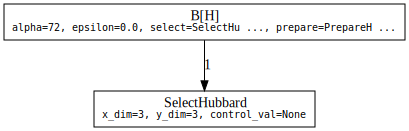

#### Counts totals:
 - `SelectHubbard(3, 3)`: 1

In [7]:
from qualtran.resource_counting.generalizers import ignore_split_join
lcu_block_g, lcu_block_sigma = lcu_block.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(lcu_block_g)
show_counts_sigma(lcu_block_sigma)

## `LCUBlockEncodingZeroState`
LCU based block encoding using SELECT and PREPARE oracles.

Builds the standard block encoding from an LCU as
$$
    B[H] = \mathrm{PREPARE}^\dagger \cdot \mathrm{SELECT} \cdot \mathrm{PREPARE},
$$
where
$$
    \mathrm{PREPARE} |0\rangle_a = \sum_l \sqrt{\frac{w_l}{\alpha}} |l\rangle_a,
$$
and
$$
    \mathrm{SELECT} |l\rangle_a|\psi\rangle_s = |l\rangle_a U_l |\psi\rangle_s.
$$

The Hamiltonian can be extracted via

$$
    \langle G | B[H] | G \rangle = H / \alpha,
$$
where $|G\rangle_a = I_a |0\rangle_a$

The ancilla register is at least of size $\log L$.

In our implementations we typically split the ancilla registers into
selection registers (i.e.  the $l$ registers above) and junk registers which
are extra qubits needed by state preparation but not controlled upon during
SELECT.

#### Parameters
 - `alpha`: The normalization constant upper bounding the spectral norm of the Hamiltonian. Often called lambda.
 - `epsilon`: The precision to which the block encoding is performed. Currently this isn't used: see https://github.com/quantumlib/Qualtran/issues/985
 - `select`: The bloq implementing the `SelectOracle` interface.
 - `prepare`: The bloq implementing the `PrepareOracle` interface. 

#### Registers
 - `selection`: The combined selection register.
 - `junk`: Additional junk registers not prepared upon.
 - `system`: The combined system register. 

#### References
 - [Hamiltonian Simulation by Qubitization](https://quantum-journal.org/papers/q-2019-07-12-163/).     Low et al. 2019. Sec 3.1, page 7 and 8 for high level overview and definitions. A     block encoding is called a standard form encoding there.
 - [The power of block-encoded matrix powers: improved regression techniques via faster Hamiltonian simulation](https://arxiv.org/abs/1804.01973).     Chakraborty et al. 2018. Definition 3 page 8.


In [8]:
from qualtran.bloqs.block_encoding import LCUBlockEncodingZeroState

### Example Instances

In [9]:
from qualtran.bloqs.chemistry.hubbard_model.qubitization import PrepareHubbard, SelectHubbard

# 3x3 hubbard model U/t = 4
dim = 3
select = SelectHubbard(x_dim=dim, y_dim=dim)
U = 4
t = 1
prepare = PrepareHubbard(x_dim=dim, y_dim=dim, t=t, u=U)
N = dim * dim * 2
qlambda = 2 * N * t + (N * U) // 2
lcu_zero_state_block = LCUBlockEncodingZeroState(
    select=select, prepare=prepare, alpha=qlambda, epsilon=0.0
)

In [10]:
from qualtran.bloqs.block_encoding import BlackBoxPrepare, BlackBoxSelect
from qualtran.bloqs.chemistry.hubbard_model.qubitization import PrepareHubbard, SelectHubbard

# 3x3 hubbard model U/t = 4
dim = 3
select = SelectHubbard(x_dim=dim, y_dim=dim)
U = 4
t = 1
prepare = PrepareHubbard(x_dim=dim, y_dim=dim, t=t, u=U)
N = dim * dim * 2
qlambda = 2 * N * t + (N * U) // 2
black_box_lcu_zero_state_block = LCUBlockEncodingZeroState(
    select=BlackBoxSelect(select), prepare=BlackBoxPrepare(prepare), alpha=qlambda, epsilon=0.0
)

#### Graphical Signature

In [11]:
from qualtran.drawing import show_bloqs
show_bloqs([lcu_zero_state_block, black_box_lcu_zero_state_block],
           ['`lcu_zero_state_block`', '`black_box_lcu_zero_state_block`'])

### Call Graph

xxxx


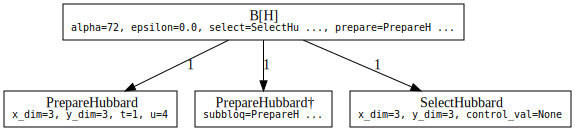

#### Counts totals:
 - `Adjoint(subbloq=PrepareHubbard)`: 1
 - `PrepareHubbard`: 1
 - `SelectHubbard(3, 3)`: 1

In [12]:
from qualtran.resource_counting.generalizers import ignore_split_join
lcu_zero_state_block_g, lcu_zero_state_block_sigma = lcu_zero_state_block.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(lcu_zero_state_block_g)
show_counts_sigma(lcu_zero_state_block_sigma)

## `ChebyshevPolynomial`
Block encoding of $T_j[H]$ where $T_j$ is the $j$-th Chebyshev polynomial.

Here H is a Hamiltonian with spectral norm $|H| \le 1$, we assume we have
an $n_L$ qubit ancilla register, and assume that $j > 0$ to avoid block
encoding the identity operator.

Recall:

\begin{align*}
    T_0[H] &= \mathbb{1} \\
    T_1[H] &= H \\
    T_2[H] &= 2 H^2 - \mathbb{1} \\
    T_3[H] &= 4 H^3 - 3 H \\
    &\dots
\end{align*}

See https://github.com/quantumlib/Qualtran/issues/984 for an alternative.

#### Parameters
 - `block_encoding`: Block encoding of a Hamiltonian $H$, $\mathcal{B}[H]$. Assumes the $|G\rangle$ state of the block encoding is the identity operator.
 - `order`: order of Chebychev polynomial. 

#### References
 - [Quantum computing enhanced computational catalysis](https://arxiv.org/abs/2007.14460).     von Burg et al. 2007. Page 45; Theorem 1.


In [13]:
from qualtran.bloqs.block_encoding import ChebyshevPolynomial

### Example Instances

In [14]:
from qualtran.bloqs.block_encoding import LCUBlockEncodingZeroState
from qualtran.bloqs.chemistry.hubbard_model.qubitization import PrepareHubbard, SelectHubbard

dim = 3
select = SelectHubbard(x_dim=dim, y_dim=dim)
U = 4
t = 1
prepare = PrepareHubbard(x_dim=dim, y_dim=dim, t=t, u=U)
N = dim * dim * 2
qlambda = 2 * N * t + (N * U) // 2
block_bloq = LCUBlockEncodingZeroState(
    select=select, prepare=prepare, alpha=qlambda, epsilon=0.0
)
chebyshev_poly = ChebyshevPolynomial(block_bloq, order=3)

In [15]:
from qualtran.bloqs.block_encoding import (
    BlackBoxPrepare,
    BlackBoxSelect,
    LCUBlockEncodingZeroState,
)
from qualtran.bloqs.chemistry.hubbard_model.qubitization import PrepareHubbard, SelectHubbard

dim = 3
select = SelectHubbard(x_dim=dim, y_dim=dim)
U = 4
t = 1
prepare = PrepareHubbard(x_dim=dim, y_dim=dim, t=t, u=U)
N = dim * dim * 2
qlambda = 2 * N * t + (N * U) // 2
black_box_block_bloq = LCUBlockEncodingZeroState(
    select=BlackBoxSelect(select), prepare=BlackBoxPrepare(prepare), alpha=qlambda, epsilon=0.0
)
black_box_chebyshev_poly = ChebyshevPolynomial(black_box_block_bloq, order=3)

#### Graphical Signature

In [16]:
from qualtran.drawing import show_bloqs
show_bloqs([chebyshev_poly, black_box_chebyshev_poly],
           ['`chebyshev_poly`', '`black_box_chebyshev_poly`'])

### Call Graph

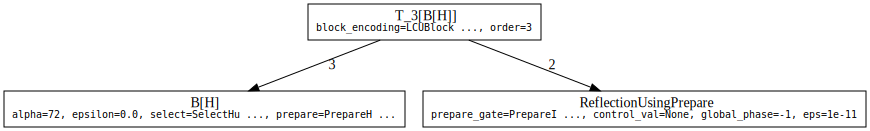

#### Counts totals:
 - `LCUBlockEncodingZeroState`: 3
 - `ReflectionUsingPrepare`: 2

In [17]:
from qualtran.resource_counting.generalizers import ignore_split_join
chebyshev_poly_g, chebyshev_poly_sigma = chebyshev_poly.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(chebyshev_poly_g)
show_counts_sigma(chebyshev_poly_sigma)